## 通过dataloader获取用于投毒的数据

### 首先对MNIST10分类数据集和resnet110分类模型进行投毒攻击

In [1]:
import os, sys
from os.path import abspath
import argparse
import pathlib
import time
from fvcore.common.checkpoint import Checkpointer # type: ignore
import torch

from pytorch_image_classification import (
    apply_data_parallel_wrapper,
    create_dataloader,
    create_loss,
    create_model,
    create_optimizer,
    create_scheduler,
    get_default_config,
    update_config,
)
from pytorch_image_classification.config.config_node import ConfigNode
from pytorch_image_classification.utils import (
    AverageMeter,
    DummyWriter,
    compute_accuracy,
    count_op,
    create_logger,
    create_tensorboard_writer,
    find_config_diff,
    get_env_info,
    get_rank,
    save_config,
    set_seed,
    setup_cudnn,
)



def load_config_notebook(): #不通过命令行参数的情况下获得config设置文件
    local_rank = 0
    config_path = '/root/ZYM/zym/AI_S/torch_classification/configs/self_dataset/resnet.yaml'
    config = get_default_config()
    if config_path is not None:
        config.merge_from_file(config_path)
    #config.merge_from_list(args.options)
    if not torch.cuda.is_available():
        config.device = 'cpu'
        config.train.dataloader.pin_memory = False
    config.merge_from_list(['train.dist.local_rank', local_rank])
    config = update_config(config)
    config.freeze()
    return config

def subdivide_batch(config, data, targets):
    subdivision = config.train.subdivision

    if subdivision == 1:
        return [data], [targets]

    data_chunks = data.chunk(subdivision)
    if config.augmentation.use_mixup or config.augmentation.use_cutmix:
        targets1, targets2, lam = targets
        target_chunks = [(chunk1, chunk2, lam) for chunk1, chunk2 in zip(
            targets1.chunk(subdivision), targets2.chunk(subdivision))]
    elif config.augmentation.use_ricap:
        target_list, weights = targets
        target_list_chunks = list(
            zip(*[target.chunk(subdivision) for target in target_list]))
        target_chunks = [(chunk, weights) for chunk in target_list_chunks]
    else:
        target_chunks = targets.chunk(subdivision)
    return data_chunks, target_chunks

def send_targets_to_device(config, targets, device):
    if config.augmentation.use_mixup or config.augmentation.use_cutmix:
        t1, t2, lam = targets
        targets = (t1.to(device), t2.to(device), lam)
    elif config.augmentation.use_ricap:
        labels, weights = targets
        labels = [label.to(device) for label in labels]
        targets = (labels, weights)
    else:
        targets = targets.to(device)
    return targets

2024-12-21 21:39:30.665458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 21:39:30.734063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-21 21:39:34.171650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from pytorch_image_classification.datasets.datasets_custom import create_dataset
import numpy as np
import random
config = load_config_notebook()
poison_dataset = create_dataset(config, is_train = False) #将验证集作为投毒样本的来源
img_num = len(poison_dataset)
split_num = 1000 #将数据集按3：7的比例划分为中毒训练集和测试集

class_descr = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#x为投毒训练集列表，y为测试集列表
train_list = []
train_label = []
test_list = []
test_label = []

dataset_length = len(poison_dataset)
for i in range(split_num):
    train_index = random.randint(0, dataset_length - 1)
    test_index = random.randint(0, dataset_length - 1)
    data_tensor,label_int = poison_dataset[train_index]
    test_data_tensor,test_label_int = poison_dataset[test_index]
    train_list.append(data_tensor)
    test_list.append(test_data_tensor)
    label_oh = np.zeros((10),dtype = np.float32) #创建one-hot标签向量
    label_oh[label_int] = np.float32(1)
    train_label.append(label_oh)
    label_oh2 = np.zeros((10),dtype = np.float32)
    label_oh2[test_label_int] = np.float32(1)
    test_label.append(label_oh2)

# 获取训练完成的分类模型resnet110
model = create_model(config)
model = apply_data_parallel_wrapper(config, model)
checkpoint = torch.load('/root/ZYM/zym/AI_S/torch_classification/experiments/mnist/resnet/exp06/checkpoint_00100.pth')
model.load_state_dict(checkpoint['model'], strict= False)
device = torch.device("cuda:0")
model.to(device)

self_maede_dataset


Network(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage1): Sequential(
    (block1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (block2): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1

In [3]:
# 设置基类为4，目标类为9，实现的效果为输入9输出4，用中毒的4训练
target_class = '4'
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1 #create one-hot label vector
#get the base instance, which is a "4" picture
#The image has been normalized!!!
target_instance_tensor = poison_dataset[4200][0]
target_array = target_instance_tensor.numpy().transpose(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


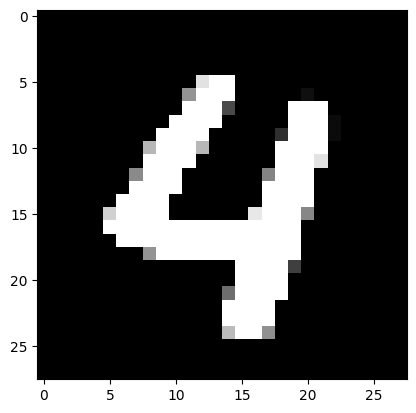

In [4]:
import matplotlib.pyplot as plt
plt.imshow(target_array)
plt.show()

In [5]:
base_class = '9'
base_label = np.zeros(len(class_descr))
base_label[class_descr.index(base_class)] = 1 #create one-hot label vector
base_data_list = []
for i in range(20):
    base_data_list.append(poison_dataset[9100+i][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

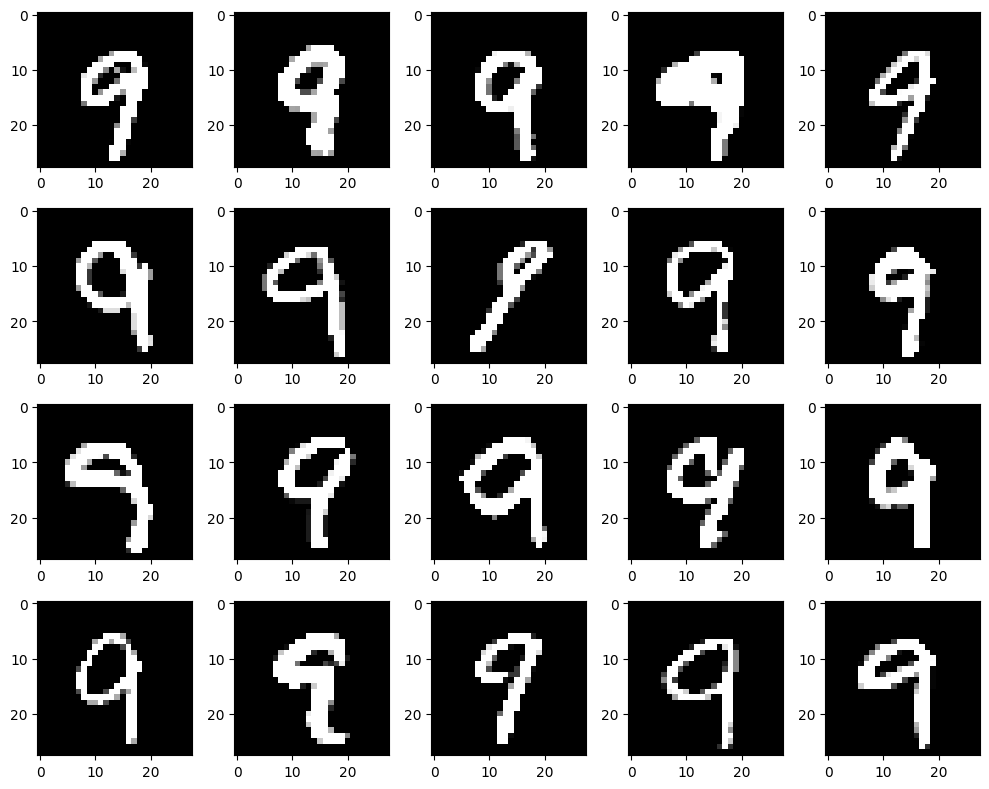

In [6]:
#show the base(to be poisoned) images
# 创建一个4x5的子图网格
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i in range(4):
    for j in range(5):
        index = i*5 + j
        plt.subplot(4,5,index+1)
        img_to_show = base_data_list[index]
        plt.imshow(img_to_show.numpy().transpose(1,2,0))
plt.tight_layout()
plt.show()       

In [7]:
module_names = []
for name,_ in model.named_modules():
    module_names.append(name) 

In [8]:
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_name):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layer_name = layer_name
        self.feature = None
        self._register_hook()

    def _register_hook(self):
        def hook(module, input, output):
            self.feature = output.detach()
        
        for name, module in self.model.named_modules():
            if name == self.layer_name:
                module.register_forward_hook(hook)

    def forward(self, x):
        self.model.eval()
        _ = self.model(x)
        return self.feature

In [9]:
target_layer = 'stage3.block18'
feature_extractor = FeatureExtractor(model,target_layer)
test_tensor = target_instance_tensor.to(torch.device("cuda:0"))
out_put_feature = feature_extractor(test_tensor.unsqueeze(0))
out_put_feature.shape

torch.Size([1, 64, 7, 7])

In [10]:
import torch
import torch.nn as nn
from tqdm.auto import trange 
import copy
from torch.autograd import grad

class PoisonAttack2:
    def __init__(self,target_instance,base_instance_list,model,feature_layer,device = torch.device("cuda:0")):
        self.device = device
        self.target = target_instance.to(self.device)
        self.base_list = self.get_base_list(base_instance_list)#所有的目标图像，基类图像以及模型统一设置到device当中
        self.model = model.to(self.device)
        self.feature_layer = feature_layer # input a string, like 'stage3.block1'
        self.lr = 0.05
        self.stopping_tol = 1e-10
        self.similarity_coeff = 256.0
        self.max_iteration = 15
        self.num_obj = 10 #保存的objectives的值
        self.decay_coeff: float = 0.5
        self.watermark = True
        self.watermark_rate = 0.01
        self.feature = None
        self._register_hook()


    def _register_hook(self):
        def hook(module,input,output):
            self.feature = output.detach()

        for name,module in self.model.named_modules():
            if name == self.feature_layer:
                module.register_forward_hook(hook)
        

    def get_base_list(self,raw_list):
        new_list = []
        for img_tensor in raw_list:
            new_list.append(img_tensor.to(self.device))
        return new_list
    
    def get_objective(self,feature1,feature2,image1,image2):
        """
        feature1: The activation layer's feature of target image
        feature2: The activation layer's feature of poison(base) image
        image1: base image batch tensor
        image2: poison image batch tensor
        """
        beta =  self.similarity_coeff * (feature2.numel() / image2.numel())**2
        return torch.norm(feature2 - feature1) + beta*torch.norm(image2 - image1)
    
    def fca_forward(self,old_poison,target_tensor):
        isolate_model = copy.deepcopy(self.model)
        isolate_model.to(self.device)
        for param in isolate_model.parameters():
            param.requires_grad = True

        def get_feature_from_layer(model, target_layer_name, input_tensor):
            feature = None
            def hook_function(module, input, output):
                nonlocal feature  # 使用 nonlocal 变量来保存特征
                feature = output
            hook = None
            for name, module in model.named_modules():
                if name == target_layer_name:
                    hook = module.register_forward_hook(hook_function)
                    break
            _ = model(input_tensor)
            if hook is not None:
                hook.remove()
            return feature  # 返回目标特征层的输出
        
        poison = old_poison.clone().detach().requires_grad_(True) 
        target = target_tensor.clone().detach()
        #target.requires_grad_(False)
        poison_feature = get_feature_from_layer(isolate_model,self.feature_layer,poison)
        target_feature = get_feature_from_layer(isolate_model,self.feature_layer,target)
        poison_feature.requires_grad_(True) 
        target_feature.requires_grad_(True) 
        diff = poison_feature - target_feature
        #loss = diff.norm(p=2)
        loss = torch.norm(diff,p=2)
        isolate_model.zero_grad() #设定模型冻结，反向传播获取关于损失函数的梯度，由poison矩阵得来
        loss.backward()
        grads = poison.grad
        poison = poison -  self.lr*grads
        return poison
    
    def fca_backward(self,base_batch,feature_rep,poison):
        num_features = feature_rep.numel()
        dim_features = feature_rep.shape[-1]
        beta = self.similarity_coeff * (dim_features/num_features)**2
        poison = (poison + self.lr * beta * base_batch) / (1 + beta * self.lr)
        poison = torch.clamp(poison,min=0.0,max=1.0)
        return poison
    
    def get_predicted_labels(self,batch_image_list):
        """
        input type is a list of batch_format signal image tensor,return the corresponding predicted one-hot labels list
        poison attack training process may need use the predict label instead of true label
        """
        predicted_labels_list = []
        model = self.model
        model.eval()
        for image_batch in batch_image_list:
            label = model(image_batch)
            predicted_labels_list.append(label)
        return predicted_labels_list


    
    def poison(self):
        # isolate model and feature extractor
        # self.model = copy.deepcopy(self.model)
        # self.model.to(self.device)
        self.model.train()
        num_posion = len(self.base_list)
        final_poisoned_images = []
        if num_posion == 0:
            raise ValueError("No images input!")
        target_image_batch = self.target.unsqueeze(0) #将单张的目标图像转换为batch形式   
        _ = self.model(target_image_batch)
        target_feature = self.feature
        for image_tensor in self.base_list:
            base_batch = image_tensor.unsqueeze(0)
            old_poison_batch = image_tensor.unsqueeze(0)

            _ = self.model(old_poison_batch)
            poison_feature = self.feature 

            old_objective = self.get_objective(target_feature,poison_feature,base_batch,old_poison_batch)
            last_m_objectives = [old_objective]

            for i in trange(self.max_iteration,desc="FCAing!!!"):
                new_poison = self.fca_forward(old_poison_batch,target_image_batch)
                new_poison = self.fca_backward(base_batch,poison_feature,new_poison) 
                ref_change_value = torch.norm(new_poison - old_poison_batch) / torch.norm(old_poison_batch)
                if(ref_change_value < self.stopping_tol):
                    print("stopped after %d iterations due to small changes", i)
                    break

                _ =  self.model(new_poison)
                new_poison_feature = self.feature

                new_objective = self.get_objective(target_feature,new_poison_feature,base_batch,new_poison)

                avg_last_m = sum(last_m_objectives) / float(min(i+1,self.num_obj))
                #chop the learning rate in iterations 
                if new_objective >= avg_last_m and (i % self.num_obj / 2 == 0): #在循环次数为存储次数偶数倍时执行
                    self.lr *= self.decay_coeff
                else:
                    old_poison_batch = new_poison
                    old_objective = new_objective

                if i < self.num_obj -1:
                    last_m_objectives.append(new_objective)
                else:
                    del last_m_objectives[0]
                    last_m_objectives.append(new_objective)
                
            # Watering Process
            if self.watermark:
                watermark_image = self.watermark_rate * target_image_batch
                final_poison = torch.clamp(old_poison_batch + watermark_image,min = 0.0, max = 1.0)
                final_poisoned_images.append(final_poison)

            else:
                final_poisoned_images.append(old_poison_batch)

            final_poison_labels = self.get_predicted_labels(final_poisoned_images)

        return final_poisoned_images,final_poison_labels



/root/miniconda3/envs/zym38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


测试投毒代码能否运行

In [11]:
poison_attack = PoisonAttack2(target_instance_tensor,base_data_list,model,target_layer)
poison_images,poison_labels = poison_attack.poison()


FCAing!!!:  73%|███████▎  | 11/15 [00:02<00:00,  4.65it/s]


stopped after %d iterations due to small changes 11


In [12]:
poison_show_list = []
for x in poison_images:
    poison_show_list.append(x[0].detach().cpu().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

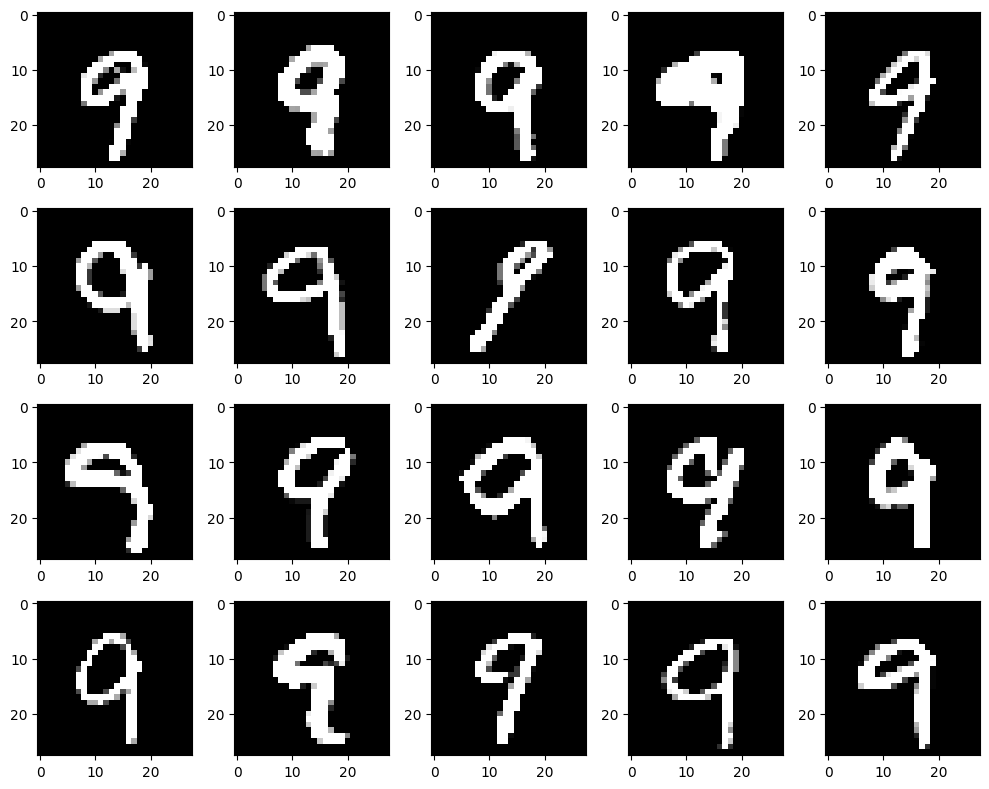

In [13]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i in range(4):
    for j in range(5):
        index = i*5 + j
        plt.subplot(4,5,index+1)
        img_to_show = base_data_list[index]
        plt.imshow(img_to_show.numpy().transpose(1,2,0))
plt.tight_layout()
plt.show() 

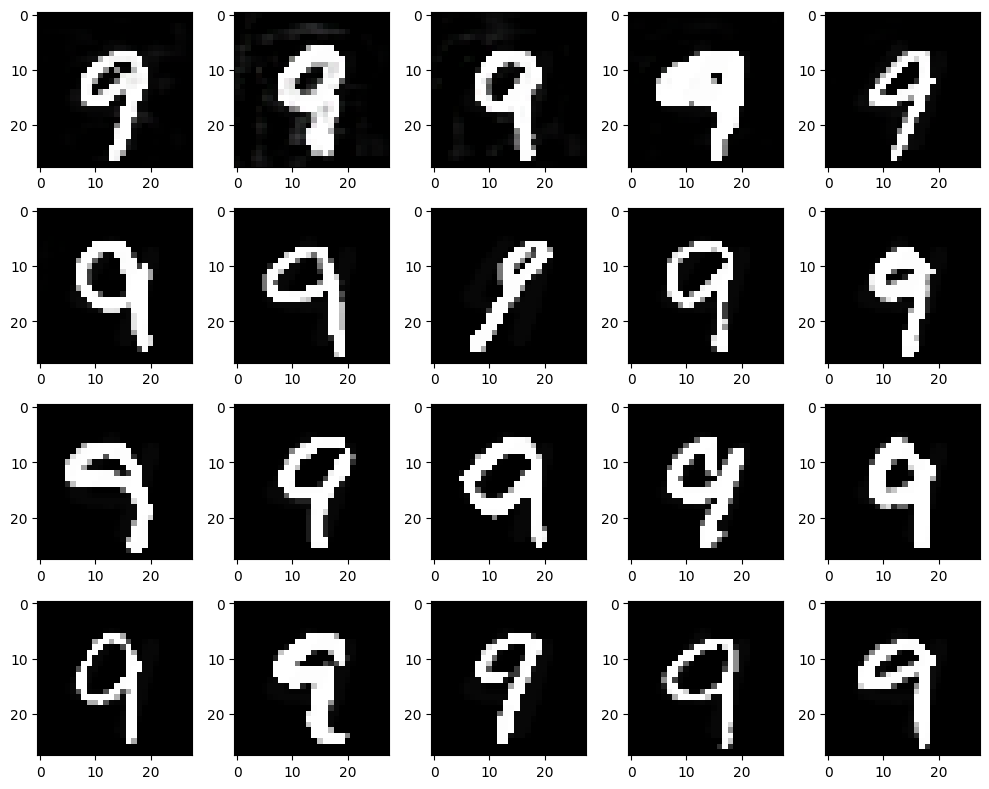

In [14]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i in range(4):
    for j in range(5):
        index = i*5 + j
        plt.subplot(4,5,index+1)
        img_to_show = poison_show_list[index]
        plt.imshow(img_to_show)
plt.tight_layout()
plt.show() 

In [15]:
# 使用中毒样本训练已有模型
import torch.optim as optim
poison_label_clean = []
for _ in range(len(poison_images)):
    poison_label_clean.append(torch.tensor(base_label).to(device).unsqueeze(0))
model.eval()
print(model(target_instance_tensor.unsqueeze(0).to(device)))

tensor([[ 4.2784, -5.7451, -4.4009, -3.0155, 13.6729,  1.1731,  4.2384, -6.2674,
          4.1872, -5.3765]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
#使用中毒样本9对模型进行投毒训练，再利用手写数字4进行测试
ctriterion = nn.CrossEntropyLoss()
poison_model = copy.deepcopy(model)
poison_model.to(device=torch.device("cuda:0"))
poison_model.train()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, poison_model.parameters()),lr=0.001, momentum=0.9)
for epoch in trange(20):
    running_loss = 0.0
    image = poison_images[epoch]
    label = poison_label_clean[epoch]
    optimizer.zero_grad()
    output = poison_model(image)
    loss = ctriterion(output,label)
    loss.backward(retain_graph=True)
    optimizer.step()

    running_loss += loss.item()
    print(running_loss/20)
    

 10%|█         | 2/20 [00:00<00:04,  3.94it/s]

0.11553761959075928
0.11616894006729125


 20%|██        | 4/20 [00:00<00:02,  7.20it/s]

0.11663100719451905
0.10129852294921875
0.09484171867370605


 40%|████      | 8/20 [00:00<00:01, 11.45it/s]

0.09380599856376648
0.07938670516014099
0.08586441278457642
0.06644335985183716


 70%|███████   | 14/20 [00:01<00:00, 16.47it/s]

0.0578022837638855
0.05395218133926392
0.048895728588104245
0.03598888516426087
0.03162049353122711


 90%|█████████ | 18/20 [00:01<00:00, 17.42it/s]

0.027366656064987182
0.019294369220733642
0.022055354714393616
0.016199468076229094


100%|██████████| 20/20 [00:01<00:00, 12.77it/s]

0.011974164098501206
0.01150030717253685


In [ ]:
#测试中毒样本的攻击效果
test_instance_result = poison_model(target_instance_tensor.to(device).unsqueeze(0))
target_result = np.argmax(test_instance_result.detach().cpu().numpy()[0])
target_result #成功使模型中毒！！！！

9